# Prospecção de Dados (Data Mining) DI/FCUL - HA2

## Course Project (MC/DI/FCUL - 2024)

### GROUP: `02`

* João Martins, 62532 - Hours worked on the project: 16
* Rúben Torres, 62531 - Hours worked on the project: 16
* Nuno Pereira, 56933 - Hours worked on the project: 16

### 1. Import the dataset

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr

with open("mol_bits.pkl", "rb") as file:
    molecular_fingerprints = pickle.load(file)

# Convert molecular fingerprints to DataFrame
mol_df = pd.DataFrame(
    list(molecular_fingerprints.items()), columns=["Molecules", "Fingerprint"]
)
mol_df

,Molecules,Fingerprint
0,CHEMBL2022243,"[10, 38, 50, 80, 107, 113, 180, 217, 315, 322,..."
1,CHEMBL2022244,"[10, 38, 50, 80, 107, 113, 180, 217, 315, 322,..."
2,CHEMBL2022245,"[10, 38, 50, 80, 104, 107, 113, 180, 184, 217,..."
3,CHEMBL2022246,"[10, 38, 50, 80, 107, 113, 118, 123, 217, 315,..."
4,CHEMBL2022247,"[10, 22, 38, 50, 66, 80, 107, 113, 160, 180, 2..."
...,...,...
73860,CHEMBL4218012,"[32, 80, 103, 147, 158, 264, 371, 389, 425, 51..."
73861,CHEMBL4217503,"[38, 80, 103, 155, 371, 389, 425, 457, 491, 51..."
73862,CHEMBL4205802,"[38, 80, 103, 115, 147, 155, 206, 371, 389, 45..."
73863,CHEMBL4204359,"[32, 80, 103, 147, 158, 264, 371, 389, 425, 49..."


In [3]:
activity = pd.read_csv(
    "activity_train.csv", header=None, names=["Proteins", "Molecules", "Rate"]
)
activity

,Proteins,Molecules,Rate
0,O14842,CHEMBL2022243,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [4]:
activity_test = pd.read_csv(
    "activity_test_blanked.csv", header=None, names=["Proteins", "Molecules", "Rate"]
)
activity_test

,Proteins,Molecules,Rate
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


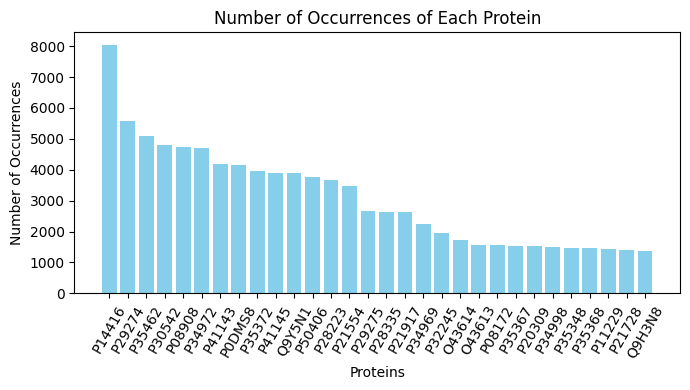

In [5]:
# Count the number of times each protein appears
protein_counts = activity['Proteins'].value_counts()

# Sort proteins by their counts in descending order
sorted_proteins = protein_counts.index.tolist()[:30]
counts = protein_counts.values[:30]

# Plot the bar chart
plt.figure(figsize=(7, 4))
plt.bar(range(len(sorted_proteins)), counts, color='skyblue')
plt.xlabel('Proteins')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Protein')
plt.xticks(range(len(sorted_proteins)), sorted_proteins, rotation=60)
plt.tight_layout()
plt.show()

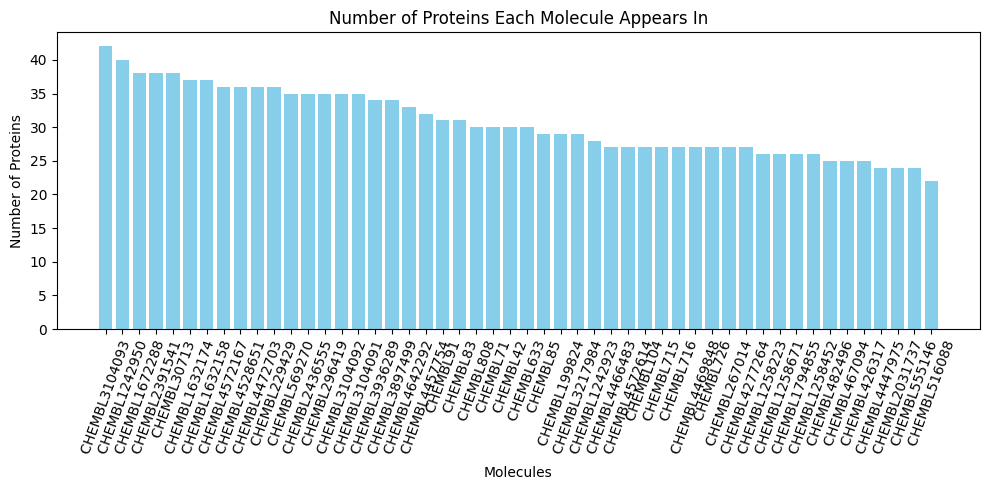

In [6]:
# Count the number of unique proteins each molecule appears in
molecule_protein_counts = activity.groupby('Molecules')['Proteins'].nunique()

# Sort molecules by the number of unique proteins they appear in, in descending order
sorted_molecules = molecule_protein_counts.sort_values(ascending=False).index.tolist()[:50]
counts = molecule_protein_counts.sort_values(ascending=False).values[:50]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_molecules)), counts, color='skyblue')
plt.xlabel('Molecules')
plt.ylabel('Number of Proteins')
plt.title('Number of Proteins Each Molecule Appears In')
plt.xticks(range(len(sorted_molecules)), sorted_molecules, rotation=70)
plt.tight_layout()
plt.show()

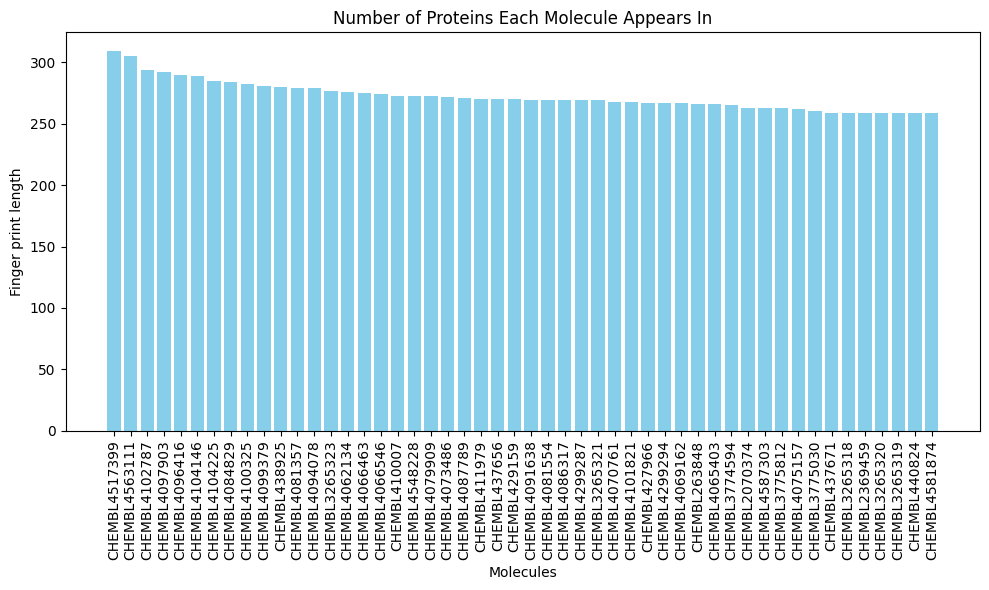

In [7]:
molecule_protein_counts = mol_df.set_index('Molecules')['Fingerprint'].apply(len)

# Sort molecules by the number of proteins they appear in, in descending order
sorted_molecules = molecule_protein_counts.sort_values(ascending=False).index.tolist()[:50]
counts = molecule_protein_counts.sort_values(ascending=False).values[:50]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_molecules)), counts, color='skyblue')
plt.xlabel('Molecules')
plt.ylabel('Finger print length')
plt.title('Number of Proteins Each Molecule Appears In')
plt.xticks(range(len(sorted_molecules)), sorted_molecules, rotation=90)
plt.tight_layout()
plt.show()

* The file activity_train.csv contains a list of interactions between molecules (identified by their ChEMBL IDs and proteins identified by their Uniprot IDs). The activity value is rated from 1 to 10, where 1 is INACTIVE and 10 is EXTREMELY POTENT.

* The file activity_test_blanked.csv has exactly the same structure as activity_train.csv, yet, the activiy values are all at Zero. The goal of the project is to predict the real values.

* Additionally it is provided the Fingerprints of molecules (mol_bits.pkl). Fingerprinting is a hashed structural representation of molecules, where each set bit represents a structural feature. Molecules that have a common bit set mean that they probably share a structural element. This file is a Zipped pickled file that contain a dictionary with keys corresponding the ChEMBL IDs and values corresponding to a list of the set bits of each molecule.

### 2. Merge the dataset

In [8]:
def convert_to_bit_vector(bit_indices, length):
    bit_vector = np.zeros(length, dtype=int)
    bit_vector[bit_indices] = 1
    return bit_vector


max_bit_index = max([max(fp) for fp in molecular_fingerprints.values()])

bit_vectors = mol_df["Fingerprint"].apply(
    lambda x: convert_to_bit_vector(x, max_bit_index + 1)
)
bit_matrix = np.vstack(bit_vectors)
bit_df = pd.DataFrame(bit_matrix, columns=[f"{i}" for i in range(max_bit_index + 1)])
mol_df = pd.concat([mol_df[["Molecules"]], bit_df], axis=1)


activity["Molecules"] = activity["Molecules"].str.strip()
mol_df["Molecules"] = mol_df["Molecules"].str.strip()
activity_test["Molecules"] = activity_test["Molecules"].str.strip()

In [9]:
merged_df = pd.merge(activity, mol_df, on="Molecules")
merged_df

merged_df_test = pd.merge(activity_test, mol_df, on="Molecules")
merged_df

,Proteins,Molecules,Rate,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,O14842,CHEMBL2022243,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,O14842,CHEMBL2022244,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O14842,CHEMBL2022245,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O14842,CHEMBL2022246,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,O14842,CHEMBL2022247,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
135707,Q9Y5Y4,CHEMBL4218012,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
135708,Q9Y5Y4,CHEMBL4217503,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135709,Q9Y5Y4,CHEMBL4204359,8,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Prepare features (X) and target variable (y)
X = merged_df.drop(columns=["Proteins", "Molecules", "Rate"])
y = merged_df["Rate"]

# X_test = merged_df_test.drop(columns=["Proteins", "Molecules", "Rate"])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### 3. PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1150)
pca.fit(X)
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
# print("Actual Eigenvalues:", pca.singular_values_)
# for i,comp in enumerate(pca.components_):
#     print("PC",i, "-->", comp)

PC0 - Variance explained:  0.0264 - Total Variance:  0.0264
PC1 - Variance explained:  0.0190 - Total Variance:  0.0454
PC2 - Variance explained:  0.0145 - Total Variance:  0.0599
PC3 - Variance explained:  0.0132 - Total Variance:  0.0732
PC4 - Variance explained:  0.0120 - Total Variance:  0.0851
PC5 - Variance explained:  0.0116 - Total Variance:  0.0967
PC6 - Variance explained:  0.0103 - Total Variance:  0.1070
PC7 - Variance explained:  0.0100 - Total Variance:  0.1170
PC8 - Variance explained:  0.0089 - Total Variance:  0.1258
PC9 - Variance explained:  0.0084 - Total Variance:  0.1342
PC10 - Variance explained:  0.0084 - Total Variance:  0.1426
PC11 - Variance explained:  0.0079 - Total Variance:  0.1505
PC12 - Variance explained:  0.0074 - Total Variance:  0.1580
PC13 - Variance explained:  0.0071 - Total Variance:  0.1651
PC14 - Variance explained:  0.0068 - Total Variance:  0.1719
PC15 - Variance explained:  0.0065 - Total Variance:  0.1784
PC16 - Variance explained:  0.0060

In [12]:
X_train_Sscaled_PCA = pca.transform(X_train)
X_test_Sscaled_PCA = pca.transform(X_test)
print(X_train_Sscaled_PCA.shape)

(108568, 1150)


### 4. ML model

In [23]:
def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

In [26]:
reg = LinearRegression().fit(X_train_Sscaled_PCA, y_train)

y_pred = reg.predict(X_test_Sscaled_PCA)

printRegStatistics(y_test, y_pred)
y_pred.shape

The RVE is:  0.228788786276937
The rmse is:  2.5287155790500586
The Correlation Score is is: 0.4785 (p-value=0.000000e+00)

The Maximum Error is is:  9.128265881634604
The Mean Absolute Error is:  2.096885287000234


c:\Users\joaom\Documents\FCUL\2ºSemestre\Prospeção_de_Dados(Data_Mining)\TP2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(27143,)

In [14]:
log = LogisticRegression().fit(X_train_Sscaled_PCA, y_train)

y_pred = log.predict(X_test_Sscaled_PCA)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
y_pred.shape

[6 1 1 ... 7 6 1]
Accuracy: 0.28231956673912245
Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.75      0.50      5979
           2       0.17      0.06      0.09      1862
           3       0.20      0.12      0.15      2712
           4       0.17      0.13      0.15      2729
           5       0.18      0.14      0.16      2979
           6       0.17      0.11      0.13      2800
           7       0.22      0.20      0.20      2687
           8       0.19      0.12      0.15      2129
           9       0.17      0.07      0.10      1426
          10       0.33      0.40      0.36      1840

    accuracy                           0.28     27143
   macro avg       0.22      0.21      0.20     27143
weighted avg       0.24      0.28      0.24     27143



(27143,)

In [21]:
Nb_classifier = GaussianNB()
Nb_classifier.fit(X_train_Sscaled_PCA, y_train)

GaussianNB()

In [22]:
y_pred = Nb_classifier.predict(X_test_Sscaled_PCA)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
y_pred.shape

[10  1  1 ...  7 10  1]
Accuracy: 0.20988836900858415
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.52      0.41      5979
           2       0.17      0.06      0.09      1862
           3       0.17      0.09      0.12      2712
           4       0.14      0.20      0.16      2729
           5       0.19      0.09      0.12      2979
           6       0.20      0.04      0.07      2800
           7       0.15      0.08      0.10      2687
           8       0.13      0.09      0.11      2129
           9       0.11      0.09      0.10      1426
          10       0.13      0.44      0.20      1840

    accuracy                           0.21     27143
   macro avg       0.17      0.17      0.15     27143
weighted avg       0.20      0.21      0.18     27143



(27143,)

In [16]:
rf_classifier = RandomForestClassifier(max_depth=40, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1)

In [17]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
y_pred.shape

[5 3 1 ... 7 6 1]
Accuracy: 0.3027299856316546
Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.74      0.57      5979
           2       0.16      0.10      0.12      1862
           3       0.19      0.15      0.17      2712
           4       0.18      0.15      0.16      2729
           5       0.19      0.17      0.18      2979
           6       0.19      0.16      0.18      2800
           7       0.21      0.19      0.20      2687
           8       0.21      0.17      0.19      2129
           9       0.20      0.14      0.16      1426
          10       0.43      0.40      0.42      1840

    accuracy                           0.30     27143
   macro avg       0.24      0.24      0.23     27143
weighted avg       0.27      0.30      0.28     27143



(27143,)

In [ ]:
# activity_test["Rate"] = y_pred

# # Write the updated DataFrame to a new CSV file
# activity_test.to_csv("activity_test_predictions.csv", index=False)
# activity_test